In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import bayesflow as bf
import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
epochs = 8
steps_per_epoch = 1024
batch_size = 1024

In [4]:
simulator = bf.simulators.TwoMoonsSimulator()
dataset = bf.datasets.OnlineDataset(simulator, batch_size=batch_size)

Visualize the target distribution with rejection sampling:

In [5]:
# rejection sample returns at least the requested number of samples
samples = simulator.rejection_sample((1024,), lambda s: keras.ops.norm(s["x"], axis=-1) < 0.01, numpy=True)

keras.ops.shape(samples["x"])

(1024, 2)

In [6]:
samples = {"x": samples["theta"][:, 0], "y": samples["theta"][:, 1]}

In [7]:
samples = {key: keras.ops.convert_to_numpy(value) for key, value in samples.items()}

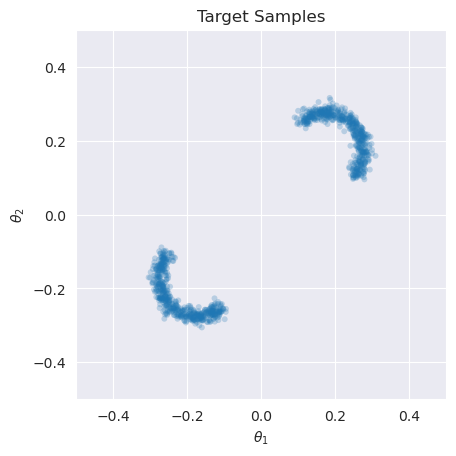

In [8]:
sns.scatterplot(samples, x="x", y="y", size=1, alpha=0.25, lw=0, legend=False)
plt.xlim((-0.5, 0.5))
plt.ylim((-0.5, 0.5))
plt.gca().set_aspect("equal")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title("Target Samples")
plt.show()

In [9]:
# inference_network = bf.networks.CouplingFlow(subnet="resnet")
inference_network = bf.networks.FlowMatching(subnet="resnet")

In [10]:
approximator = bf.Approximator(
    inference_network=inference_network,
    inference_variables=["theta"],
    inference_conditions=["x"],
)

In [11]:
learning_rate = keras.optimizers.schedules.CosineDecay(1e-3, epochs * steps_per_epoch, 1e-6)

In [12]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, global_clipnorm=1.0)

In [13]:
approximator.compile(optimizer=optimizer)

In [14]:
fit_history = approximator.fit(dataset, epochs=epochs, steps_per_epoch=steps_per_epoch)

Epoch 1/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3581
Epoch 2/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3250
Epoch 3/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3185
Epoch 4/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3156
Epoch 5/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3137
Epoch 6/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3115
Epoch 7/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3086
Epoch 8/8
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3068


In [20]:
metrics_history = fit_history.history
loss_history = metrics_history["loss"]

Text(0, 0.5, 'Loss')

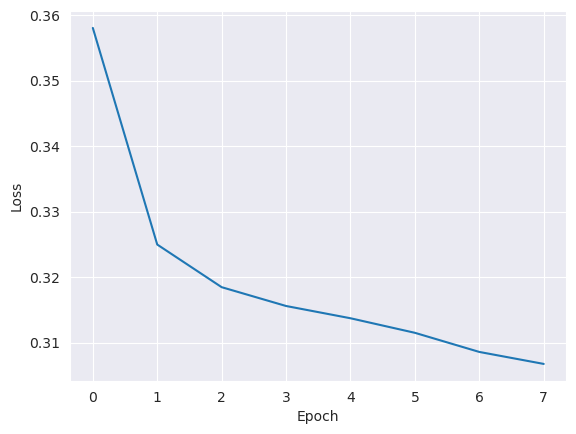

In [21]:
sns.lineplot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [22]:
data = {"x": keras.ops.zeros((1024, 2))}
samples = approximator.sample(1024, data=data, numpy=True)

In [23]:
samples = {"x": samples["theta"][:, 0], "y": samples["theta"][:, 1]}

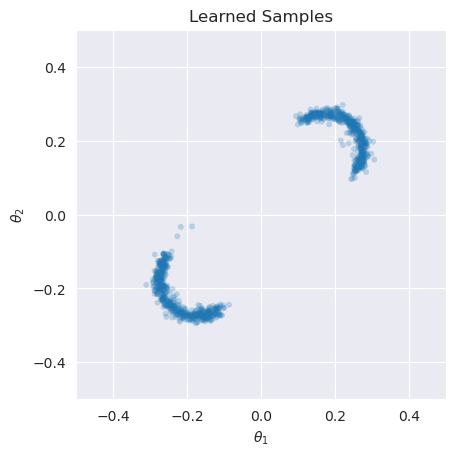

In [24]:
sns.scatterplot(samples, x="x", y="y", size=1, alpha=0.25, lw=0, legend=False)
plt.xlim((-0.5, 0.5))
plt.ylim((-0.5, 0.5))
plt.gca().set_aspect("equal")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title("Learned Samples")
plt.show()